### EDA
### Data Cleaning

### Data Validation


Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots 
import plotly.graph_objects as go

import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler


In [2]:
df= pd.read_csv("../DataSet/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Validation 

In [3]:
#DATA VALIDATION 

def validate_data(df):
    issues = {}
    
    # Validate negative values in specific columns
    columns_to_check = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    for column in columns_to_check:
        invalid_values = df[df[column] < 0]
        if not invalid_values.empty:
            issues[column] = invalid_values

    # Logical range checks
    if (df['Age'] > 120).any():
        issues['Age'] = df[df['Age'] > 120]
    if (df['CreditScore'] > 850).any():
        issues['CreditScore'] = df[df['CreditScore'] > 850]

    if issues:
        print("Data Validation Issues Detected:")
        for key, value in issues.items():
            print(f"{key}: {len(value)} invalid rows")
        return issues
    else:
        print("No validation issues detected.")
        return None

# Usage
issues = validate_data(df)


No validation issues detected.


#### Deleting Irrelevant Rows

In [4]:
df = df.drop("CustomerId", axis = 1)
df = df.drop("RowNumber", axis =1)



In [ ]:
df.columns.tolist()


['Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

#### Replacing Negative Values In CreditScore Column

In [6]:
# Replace negative CreditScore values with NaN
df['CreditScore'] = df['CreditScore'].apply(lambda x: x if x >= 0 else np.nan)

# Alternatively, replace NaNs with the median (or mean) of the column
df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


/tmp/ipykernel_6125/3004824043.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


#### Dataset Overview

In [7]:
def data_overview(df):
    print("### Dataset Overview ###")
    print("Shape of the dataset:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nFirst 5 Rows:\n", df.head())


In [8]:

data_overview(df)


### Dataset Overview ###
Shape of the dataset: (10000, 12)

Data Types:
 Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Missing Values:
 Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

First 5 Rows:
     Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0  Hargrave          619    France  Female   42       2       0.00   
1      Hill          608     Spain  Female   41       1   83807.86   
2      Onio          502    France  Female   42       8  159660.80   
3      Bon

In [9]:
def five_number_summary(df):
    print("\n### Five-Number Summary ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    summary = df[num_columns].describe(percentiles=[0.25, 0.5, 0.75]).loc[['min', '25%', '50%', '75%', 'max']]
    print(summary)
    return summary


In [10]:

five_number_summary(df)



### Five-Number Summary ###
     CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
min        350.0  18.0     0.0       0.00            1.0        0.0   
25%        584.0  32.0     3.0       0.00            1.0        0.0   
50%        652.0  37.0     5.0   97198.54            1.0        1.0   
75%        718.0  44.0     7.0  127644.24            2.0        1.0   
max        850.0  92.0    10.0  250898.09            4.0        1.0   

     IsActiveMember  EstimatedSalary  Exited  
min             0.0          11.5800     0.0  
25%             0.0       51002.1100     0.0  
50%             1.0      100193.9150     0.0  
75%             1.0      149388.2475     0.0  
max             1.0      199992.4800     1.0  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
min,350.0,18.0,0.0,0.00,1.0,0.0,0.0,11.5800,0.0
25%,584.0,32.0,3.0,0.00,1.0,0.0,0.0,51002.1100,0.0
50%,652.0,37.0,5.0,97198.54,1.0,1.0,1.0,100193.9150,0.0
75%,718.0,44.0,7.0,127644.24,2.0,1.0,1.0,149388.2475,0.0
max,850.0,92.0,10.0,250898.09,4.0,1.0,1.0,199992.4800,1.0


In [11]:

def plot_numeric_distributions(df, cols_per_row=3, bins=10):
    """
    Plot frequency distributions for numeric columns in a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        cols_per_row (int): Number of plots per row (default is 3).
        bins (int): Number of bins for the histograms (default is 10).

    Returns:
        None
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include='number')
    num_cols = len(numeric_cols.columns)
    num_rows = (num_cols + cols_per_row - 1) // cols_per_row  # Calculate number of rows needed

    # Create subplots
    fig, axarr = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 3), sharey=True)
    axarr = axarr.flatten()  # Flatten the axes for easy indexing

    for ind, col in enumerate(numeric_cols.columns):
        axarr[ind].hist(df[col], bins=bins, color='blue', alpha=0.7, edgecolor='black')
        axarr[ind].set_title(f'Distribution of {col}', fontsize=12)
        axarr[ind].set_xlabel(col)
        axarr[ind].set_ylabel('Frequency')

    # Turn off unused subplots
    for i in range(ind + 1, len(axarr)):
        axarr[i].axis('off')

    plt.tight_layout()
    plt.suptitle("Frequency Distribution of Numeric Columns", fontsize=16, y=1.05)
    plt.show()


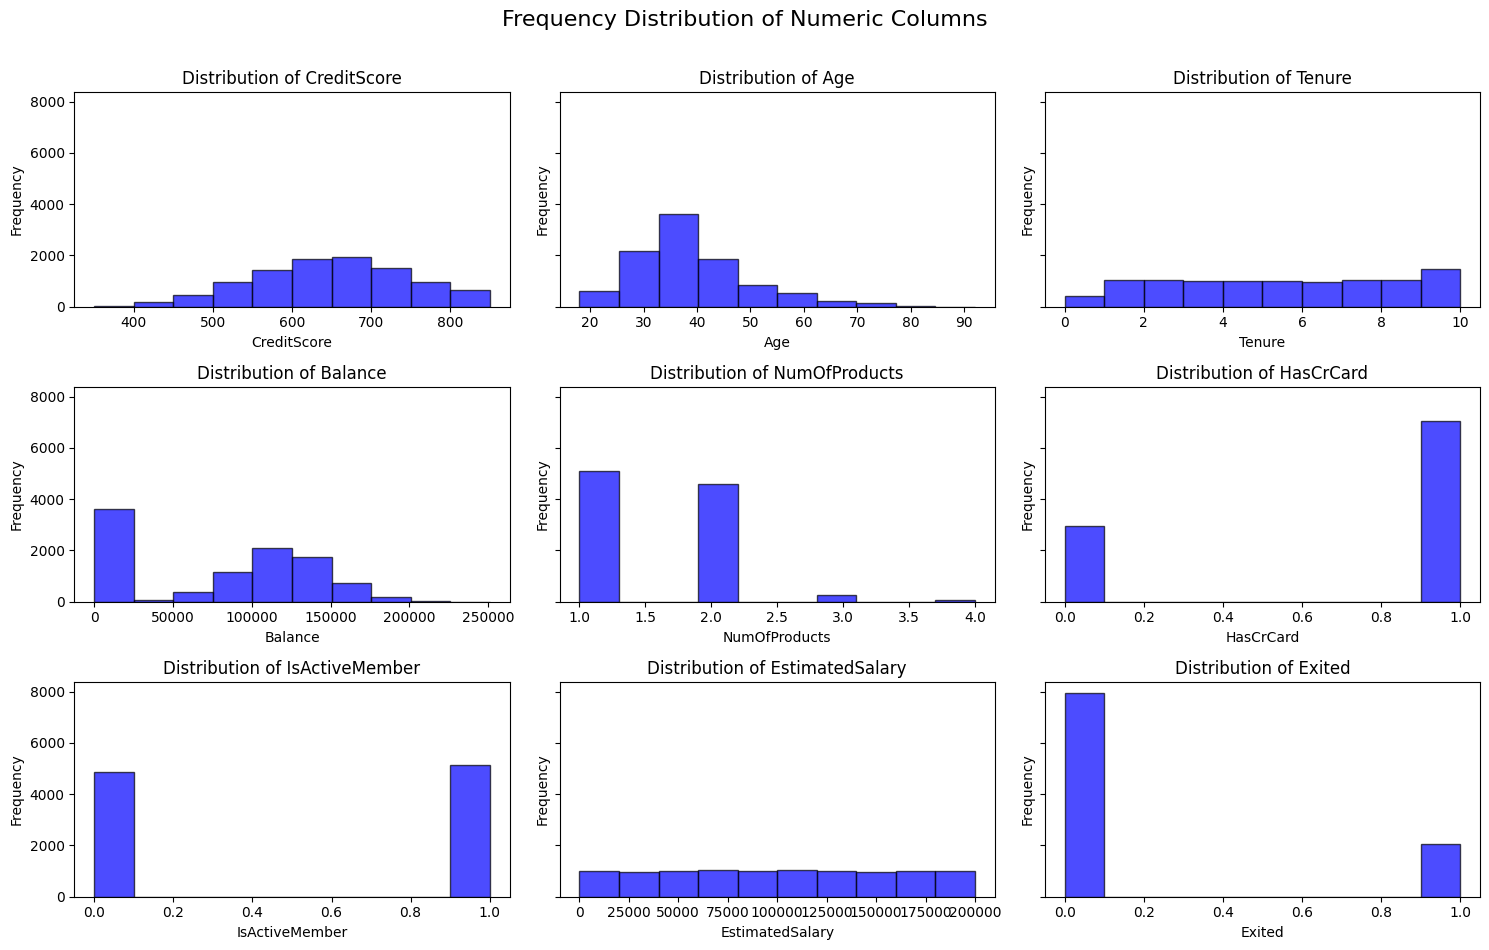

In [12]:

plot_numeric_distributions(df, cols_per_row=3, bins=10)



In [13]:
def categorical_univariate_analysis(df):
   
    print("\n### Categorical Univariate Analysis ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    num_plots = len(cat_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_columns):
        sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



### Categorical Univariate Analysis ###


/tmp/ipykernel_6125/1425442141.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_6125/1425442141.py:13: UserWarning: 
The palette list has fewer values (3) than needed (2932) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_6125/1425442141.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_6125/1425442141.py:13: FutureWarning: 

Passing `palette` without 

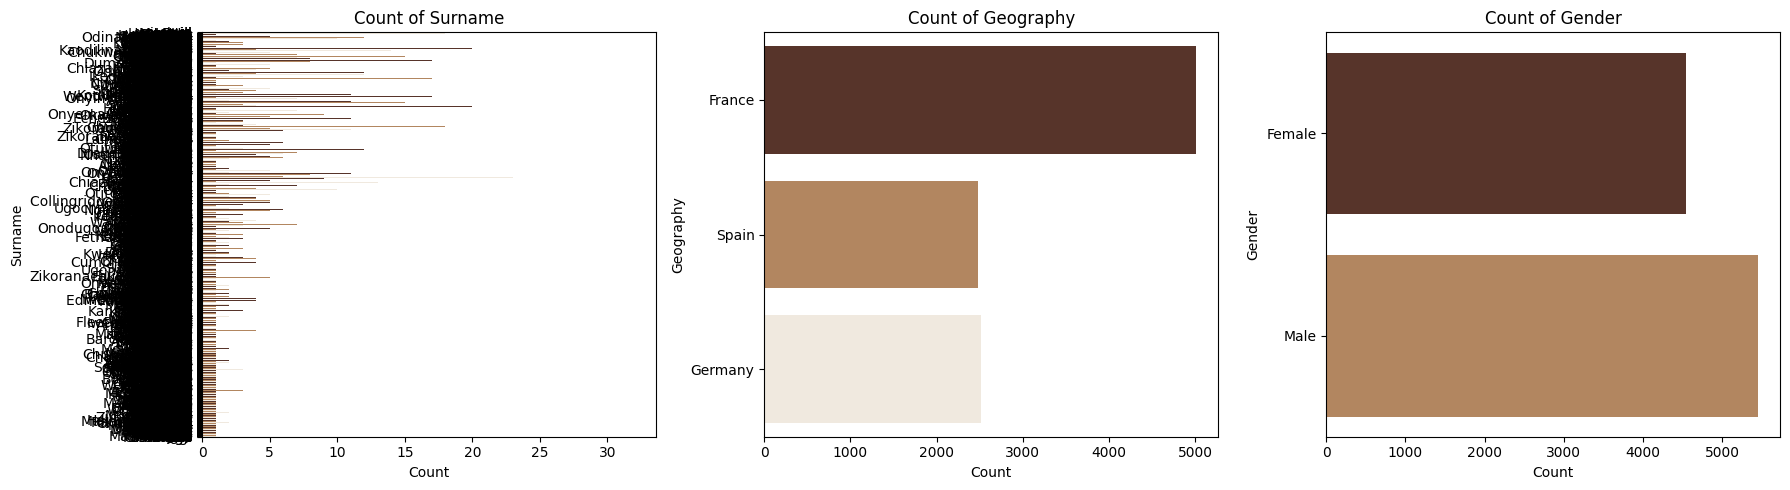

In [18]:

categorical_univariate_analysis(df)


In [19]:
def pairplot_bivariate_analysis(df, target_column):
    print("\n### Pairplot Bivariate Analysis ###")
    
    # Use the custom color for the pairplot
    custom_color = '#758ecd'  # Updated color
    
    # Pair plot for numerical variables
    sns.pairplot(df, hue=target_column, diag_kind='kde')
    plt.suptitle("Pairplot of Numerical Features", y=1.02)
    plt.show()


In [20]:

# pairplot_bivariate_analysis(df, target_column='Exited')


In [21]:
def correlation_heatmap_bivariate_analysis(df):
    print("\n### Correlation Heatmap Bivariate Analysis ###")
    num_columns = df.select_dtypes(include=[np.number]).columns

    # Create the heatmap using the custom color palette
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_columns].corr(), annot=True, cmap=['#5dd9c1', '#acfcd9', '#b084cc', '#665687', '#190933'], fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()



### Correlation Heatmap Bivariate Analysis ###


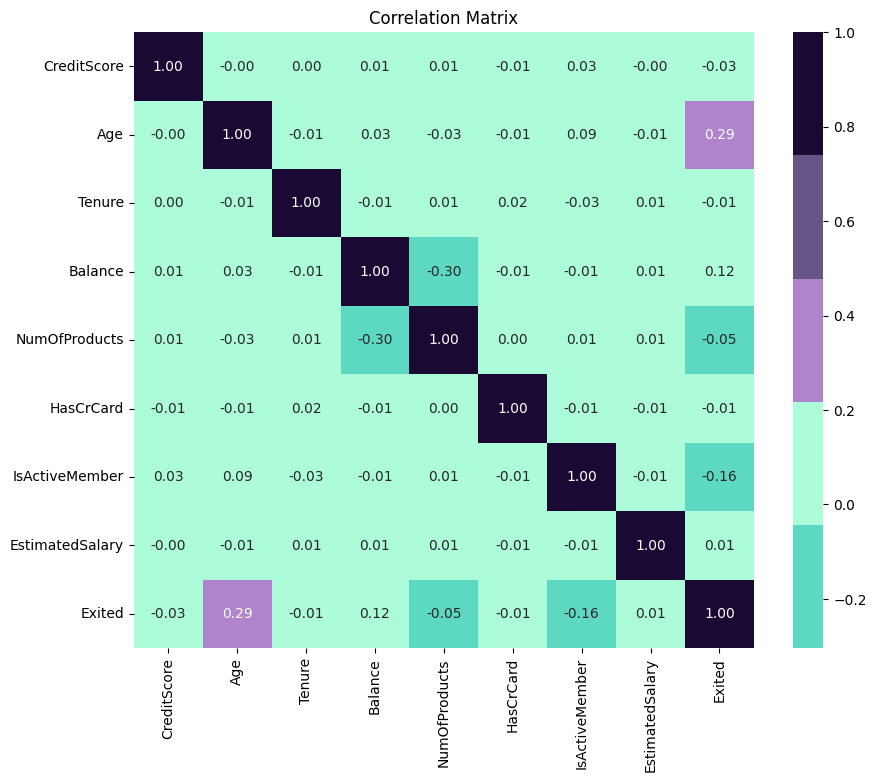

In [22]:

correlation_heatmap_bivariate_analysis(df)


In [23]:
def detect_outliers(df):
    print("\n### Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    outliers_summary = {}
    for col in num_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers detected")
    #return outliers_summary


In [24]:

detect_outliers(df)



### Outlier Detection ###
CreditScore: 15 outliers detected
Age: 359 outliers detected
Tenure: 0 outliers detected
Balance: 0 outliers detected
NumOfProducts: 60 outliers detected
HasCrCard: 0 outliers detected
IsActiveMember: 0 outliers detected
EstimatedSalary: 0 outliers detected
Exited: 2037 outliers detected


In [25]:
def box_plot_outlier_detection(df):
    
    print("\n### Box Plot for Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(num_columns):
        sns.boxplot(x=df[col], color='#758ecd', ax=axes[i])  # Custom color for the box plot
        axes[i].set_title(f'Box Plot of {col}')
        axes[i].set_xlabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



### Box Plot for Outlier Detection ###


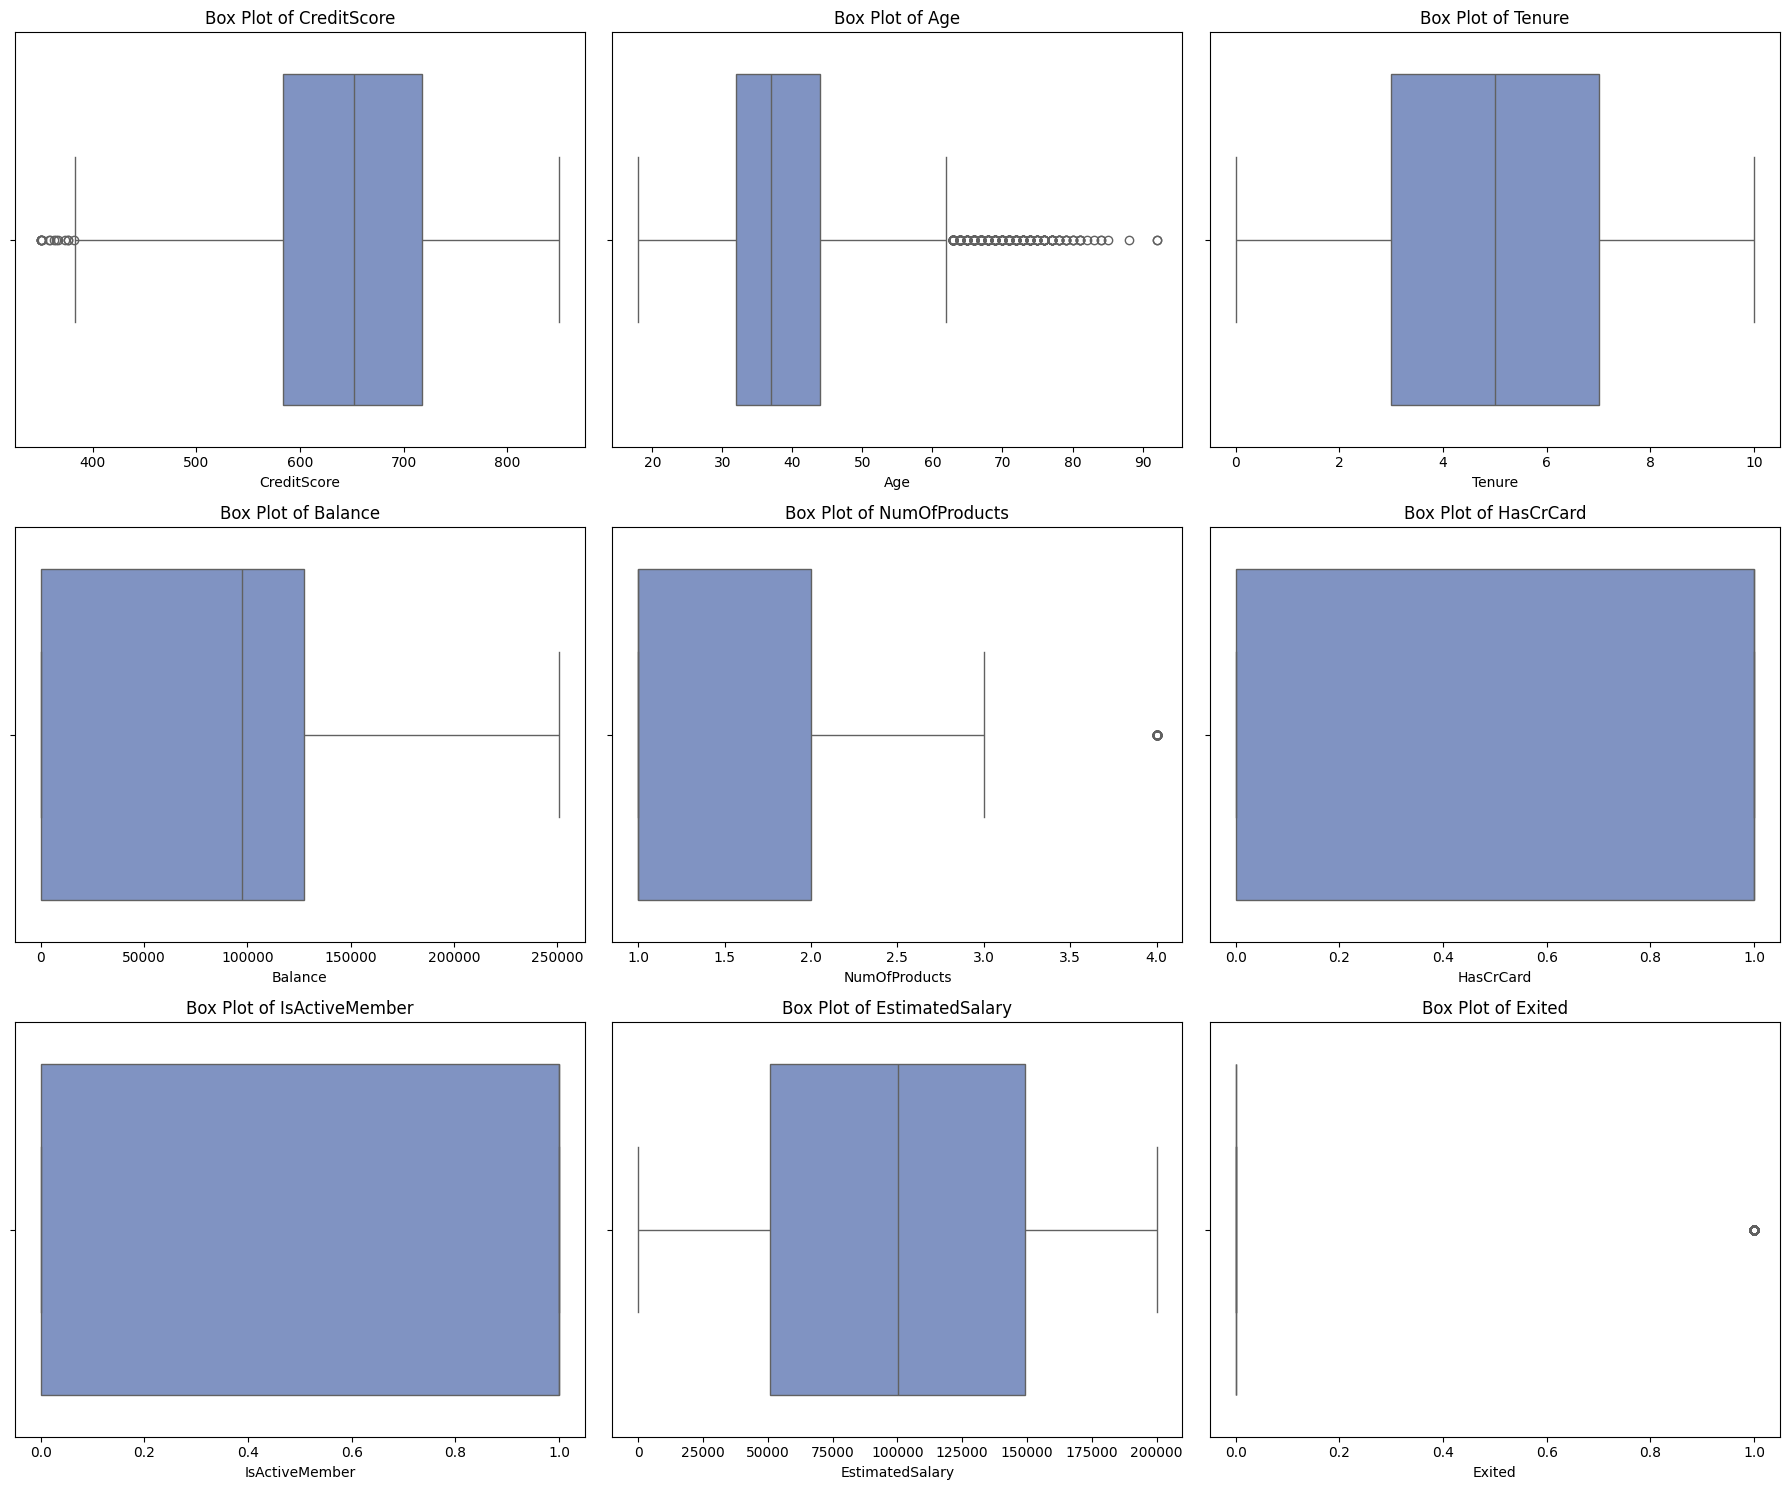

In [26]:

box_plot_outlier_detection(df)


In [27]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_numeric_boxplots(df, cols_per_row=3):
    """
    Create box plots for numeric columns in a DataFrame, arranged in multiple rows.

    Parameters:
        df (DataFrame): The input DataFrame.
        cols_per_row (int): Number of plots per row.

    Returns:
        None
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include='number')
    num_cols = len(numeric_cols.columns)
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    # Create subplots
    fig = make_subplots(
        rows=rows, cols=cols_per_row,
        subplot_titles=numeric_cols.columns
    )

    # Add box plot traces
    for i, col in enumerate(numeric_cols.columns):
        row = (i // cols_per_row) + 1
        col_position = (i % cols_per_row) + 1
        fig.add_trace(
            go.Box(y=numeric_cols[col], name=col, boxmean=True),
            row=row, col=col_position
        )

    # Update layout
    fig.update_layout(
        height=rows * 400,  # Adjust height dynamically based on the number of rows
        width=cols_per_row * 200,
        title_text="Box Plots for Numeric Columns",
        showlegend=False,
        template="plotly_dark"
    )

    # Show the figure
    fig.show()


In [28]:
plot_numeric_boxplots(df, cols_per_row=6)


#### Cleanesed Data Export To CSV File

In [29]:

# Save the cleaned dataset as a CSV file
file_path = "../DataSet/cleaned_customer_churn_data.csv"
df.to_csv(file_path, index=False)

# Check the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Check if the file exists in the directory
if os.path.exists(file_path):
    print(f"File has been saved successfully at {file_path}")
else:
    print(f"File not found at {file_path}")


Current working directory: /mnt/sda/OneDrive/Codes/CDAC_Project_work/Implementation
File has been saved successfully at ../DataSet/cleaned_customer_churn_data.csv


In [30]:
def encode_categorical(df):
    print("\n### Encoding Categorical Variables ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
    print(f"Categorical columns encoded: {list(cat_columns)}")
    return df_encoded


In [31]:

df_encoded = encode_categorical(df)



### Encoding Categorical Variables ###
Categorical columns encoded: ['Surname', 'Geography', 'Gender']


In [32]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def encoded_feature_vs_target_analysis(df, target_column, cols_per_row=2):
    """
    Create count plots for encoded categorical features against the target column, arranged in multiple rows.

    Parameters:
        df (DataFrame): The input DataFrame.
        target_column (str): The target column for the analysis.
        cols_per_row (int): Number of plots per row (default is 2).

    Returns:
        None
    """
    # Encoded categorical features
    encoded_categorical_columns = ['Geography', 'Gender']
    num_plots = len(encoded_categorical_columns)
    rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0)

    # Create subplots
    fig = make_subplots(
        rows=rows, cols=cols_per_row,
        subplot_titles=encoded_categorical_columns
    )

    # Add count plot traces
    for i, col in enumerate(encoded_categorical_columns):
        row = (i // cols_per_row) + 1
        col_position = (i % cols_per_row) + 1
        fig.add_trace(
            go.Bar(
                x=df[col],
                y=df.groupby(col)[target_column].value_counts().values,
                name=f'{col} vs {target_column}',
                marker=dict(color=['#6e5082', '#3a2b51', '#b084cc']),
            ),
            row=row, col=col_position
        )

    # Update layout
    fig.update_layout(
        height=rows * 400,  # Adjust height dynamically based on the number of rows
        width=cols_per_row * 400,
        title_text="Encoded Feature vs Target Column Analysis",
        showlegend=False,
        template="plotly_dark"
    )

    # Show the figure
    fig.show()


In [33]:

# Define the target column
target_column = 'Exited'

# Call the function with the target column
encoded_feature_vs_target_analysis(df, target_column)


In [34]:
def feature_engineering(df):
    print("\n### Feature Engineering ###")

    # 1. Example of creating an interaction feature (Age * Tenure)
    df['Age_Tenure'] = df['Age'] * df['Tenure']
    
    # 2. Creating a squared feature for Age to capture any non-linear relationship
    df['Age_Squared'] = df['Age'] ** 2

    # 3. Normalizing numerical columns (CreditScore, Balance, EstimatedSalary)
    
    scaler = StandardScaler()
    df[['CreditScore', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(df[['CreditScore', 'Balance', 'EstimatedSalary']])

    # 4. Dropping the 'Surname' column as it is unlikely to be useful
    df.drop(columns=['Surname'], inplace=True)

    print("New feature columns added:", ['Age_Tenure', 'Age_Squared'])
feature_engineering(df)



### Feature Engineering ###
New feature columns added: ['Age_Tenure', 'Age_Squared']
